# Word Embedding

Obwohl der Korpus lediglich 11000 Texte enthält, wird im Folgenden versucht die Klassifikation auf Basis von Word Embeddings (Kapitel ???) durchzuführen. Dabei kommen verschiedene Klassifikatoren zum Einsatz um zu sehen wie gut diese mit den gegebenen Bedingungen zurecht kommen. Die Wahl fällt auf LSTM, CNNs und deren Kombination.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependencies</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare data</a></span><ul class="toc-item"><li><span><a href="#Tokenize-+-Padding" data-toc-modified-id="Tokenize-+-Padding-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Tokenize + Padding</a></span></li><li><span><a href="#One-hot-encoding-of-words-or-characters" data-toc-modified-id="One-hot-encoding-of-words-or-characters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>One-hot encoding of words or characters</a></span></li></ul></li><li><span><a href="#Define-model" data-toc-modified-id="Define-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define model</a></span></li><li><span><a href="#Create-dense-model" data-toc-modified-id="Create-dense-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create dense model</a></span></li><li><span><a href="#Create-dense-on-embedded-data" data-toc-modified-id="Create-dense-on-embedded-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create dense on embedded data</a></span></li><li><span><a href="#Create-lstm-model" data-toc-modified-id="Create-lstm-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Create lstm model</a></span></li><li><span><a href="#CNN" data-toc-modified-id="CNN-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>CNN</a></span></li></ul></div>

## Dependencies

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals.joblib import Memory

from nltk.tokenize import RegexpTokenizer
import nltk
import pandas as pd
from nltk.corpus import stopwords
import FEATURE_SELECTOR_v4
import datetime
import json

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, RepeatVector, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from keras.layers.merge import concatenate
from keras import regularizers
#from keras.utils.vis_utils import plot_model



[nltk_data] Error loading tagsets: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>
Using TensorFlow backend.


In [2]:
memory = Memory(location='./tmp', verbose=0)

## Prepare data

Diese Methode dient dazu die Texte in die gewünschte Form zu bringen, sodass diese anschließend in ein Modell mit einem führenden Embedding-Layer übergeben werden können. Hierfür wird jeder Texte in ein Array mit Integern überführt, wobei jeder Integer-Wert für ein ganz bestimmtes Wort steht. 
Für die weiteren Schritte müssen die Längen der Arrays angeglichen werden. Hierfür wird eine gewünschte Länge vorgegeben. Texte die eine geringere Länge aufweisen werden mittels Padding ergänzt, wobei das Array entweder zu Beginn oder am Ende mit 0-Werten ergänzt werden. Texte, die hingegen zu lang waren, werden gekürzt, indem Wörter weggelassen werden. Als Ergebnis erhält man einen Integermatrix mit m Zeilen und n Spalten, wobei m der Anzahl der Texte und n der festgelegten Länge.

Anschließend wird das Datenset in Trainings- und Testdaten unterteilt.

In [3]:
def prepare_data(serie_texts, labels, max_len=1000, test_size=0.33, random_state=42, max_words=10000):
    """
    Input: 
        serie_texts: pd.Series with documents, 
        labels: pd.Series with labels,
        max_len: Length of the array per text after padding,
        test_size: Size of the test set,
        random_state: Random_state
        random_state: random_state
        max_words
    Output: Test and train data
    Method: Tokenizing, Indexing, Padding and splitting into test and train data
    """
    
    
    # Train Tokenizer
    tok = Tokenizer(num_words=max_words)
    tok.fit_on_texts(serie_texts)
    #Tokenizing and Indexing
    sequences = tok.texts_to_sequences(serie_texts)
    #Padding
    sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
    # Size
    print("Anzahl Dokument m:",sequences_matrix.shape[0])
    print("Anzahl Token n:",sequences_matrix.shape[1])
    # Split the dataset into test and training data
    X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, labels, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

## Ergebnisse darstellen

In [4]:
def draw_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(1)
    plt.subplot(211)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    acc_values = acc
    val_acc_values = val_acc

    plt.subplot(212)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Die Daten werden geladen


In [5]:
# Path to the data
path_data='.//datasets//constructed_2.csv'

# Load the data
df_texts=pd.read_csv(path_data,sep=',',header=0, index_col=0)

# Documents
serie_texts=df_texts.text
serie_texts.size

# Labels
labels=df_texts.label
labels.size

29588

### Tokenizing + Padding

In [6]:
# Length for padding
max_len=1000
# Size of the test set
test_size=0.33
# The most n frequent words
max_words=10000


In [7]:
X_train, X_test, y_train, y_test = prepare_data(serie_texts=serie_texts,max_len=max_len, labels=df_texts.label,test_size=test_size,max_words=max_words)

Anzahl Dokument m: 29588
Anzahl Token n: 1000


## Define model

In diesem befinden sich die Methoden um die Modell zu definieren.

In [8]:
def dense_model(data, dense_units1=128, dense_units2=64, dense_units2=32, dropout=0.2):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer=Dense(dense_units1, activation='relu')(inputs)
    layer = Dropout(dropout)(layer)
    layer=Dense(dense_units2, activation='relu')(layer)
    layer = Dropout(dropout)(layer)
    layer=Dense(dense_units3, activation='relu')(layer)
    layer = Dropout(dropout)(layer)
    layer=Dense(1, activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [9]:
def embedding_flatten_model(data, max_words,embedding_units,dense_units1=128,dense_units2=64, dropout=0.2,kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, embeddings_regularizer=None):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer = Embedding(max_words,embedding_units,input_length=max_len, embeddings_regularizer=embeddings_regularizer, activity_regularizer=activity_regularizer)(inputs)
    layer = Flatten()(layer)
    layer = Dense(dense_units1, activation='relu',kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer)(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(dropout)(layer)
    layer = Dense(dense_units2, activation='relu')(layer)
    layer = Dropout(dropout)(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model
    

In [10]:
def simple_lstm_model(data, max_words,embedding_units=32 ,lstm_units=32, dropout=0.2, recurrent_dropout=0.2):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer = Embedding(max_words,embedding_units,input_length=max_len)(inputs)
    layer = LSTM(lstm_units,recurrent_dropout=recurrent_dropout, dropout=dropout)(layer)
    layer = Dense(1,name='FC1')(layer)
    layer = Activation('relu')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [11]:
def lstm_model(data, max_words,embedding_units=32 ,lstm_units=32, dense_units=256, dropout=0.2, recurrent_dropout=0.2,embeddings_regularizer=None, activity_regularizer=None,kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer = Embedding(max_words,embedding_units,input_length=max_len,embeddings_regularizer=embeddings_regularizer,activity_regularizer=activity_regularizer)(inputs)
    layer = LSTM(lstm_units,recurrent_dropout=recurrent_dropout, dropout=dropout,activity_regularizer=activity_regularizer,kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer)(layer)
    layer = Dense(dense_units,name='FC1',kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(dropout)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [12]:
def bidirectional_lstm_model(data, max_words,embedding_units=32 ,lstm_units=32, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer = Embedding(max_words,embedding_units,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(lstm_units,recurrent_dropout=recurrent_dropout, dropout=dropout,kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer))(layer)
    layer = Dense(1,name='FC1',kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer)(layer)
    layer = Activation('relu')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [13]:
def cnn(data, max_words, embedding_units,conv_1_filter=32,conv_1_length=7, pooling_length= 5,conv_2_filter=32,conv_2_length=7, dropout=0.5):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer = Embedding(max_words,embedding_units,input_length=max_len)(inputs)
    layer=Conv1D(conv_1_filter, conv_1_length, activation='relu')(layer)
    layer=Dropout(dropout)(layer)
    layer=MaxPooling1D(pooling_length)(layer)
    layer=Conv1D(conv_2_filter, conv_2_length, activation='relu')(layer)
    layer=Dropout(dropout)(layer)
    layer=GlobalMaxPooling1D()(layer)
    layer=Dense(1)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model


In [14]:
def cnn_lstm_model(data, max_words, embedding_units,conv_1_filter=32,conv_1_length=7, pooling_length= 5,lstm_units=32,conv_2_filter=32,conv_2_length=7, dropout=0.2,recurrent_dropout=0.2):
    inputs = Input(name='inputs',shape=[data.shape[1]])
    layer = Embedding(max_words,embedding_units,input_length=max_len)(inputs)
    layer=Conv1D(conv_1_filter, conv_1_length, activation='relu')(layer)
    layer=Dropout(dropout)(layer)
    layer=MaxPooling1D(pooling_length)(layer)
    layer=Conv1D(conv_2_filter, conv_2_length, activation='relu')(layer)
    layer=Dropout(dropout)(layer)
    layer = LSTM(lstm_units,recurrent_dropout=recurrent_dropout, dropout=dropout)(layer)
    layer = Dense(1,name='FC1')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

## Create dense model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               128128    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 132,289
Trainable params: 132,289
Non-trainable params: 0
_________________________________________________________________
Trai

19823/19823 [==============================] - 5s 237us/step - loss: 5.1620 - acc: 0.6775 - val_loss: 5.2044 - val_acc: 0.6747
Epoch 52/500
19823/19823 [==============================] - 5s 238us/step - loss: 5.1364 - acc: 0.6789 - val_loss: 5.1881 - val_acc: 0.6755
Epoch 53/500
19823/19823 [==============================] - 5s 238us/step - loss: 5.1102 - acc: 0.6806 - val_loss: 5.2018 - val_acc: 0.6746
Epoch 54/500
19823/19823 [==============================] - 5s 241us/step - loss: 5.1108 - acc: 0.6803 - val_loss: 5.1838 - val_acc: 0.6756
Epoch 55/500
19823/19823 [==============================] - 5s 261us/step - loss: 5.1205 - acc: 0.6794 - val_loss: 5.2015 - val_acc: 0.6743
Epoch 56/500
19823/19823 [==============================] - 5s 273us/step - loss: 5.1501 - acc: 0.6776 - val_loss: 5.2346 - val_acc: 0.6722
Epoch 57/500
19823/19823 [==============================] - 5s 248us/step - loss: 5.1416 - acc: 0.6782 - val_loss: 5.1826 - val_acc: 0.6756
Epoch 58/500
19823/19823 [=======

19823/19823 [==============================] - 3s 141us/step - loss: 5.0977 - acc: 0.6811 - val_loss: 5.1573 - val_acc: 0.6773
Epoch 110/500
19823/19823 [==============================] - 7s 328us/step - loss: 5.0764 - acc: 0.6825 - val_loss: 5.1836 - val_acc: 0.6757
Epoch 111/500
19823/19823 [==============================] - 5s 274us/step - loss: 5.1268 - acc: 0.6793 - val_loss: 5.1985 - val_acc: 0.6747
Epoch 112/500
19823/19823 [==============================] - 6s 302us/step - loss: 5.1203 - acc: 0.6795 - val_loss: 5.1870 - val_acc: 0.6754
Epoch 113/500
19823/19823 [==============================] - 6s 326us/step - loss: 5.1164 - acc: 0.6798 - val_loss: 5.2034 - val_acc: 0.6742
Epoch 114/500
19823/19823 [==============================] - 6s 308us/step - loss: 5.0974 - acc: 0.6810 - val_loss: 5.1787 - val_acc: 0.6760
Epoch 115/500
19823/19823 [==============================] - 5s 268us/step - loss: 5.0795 - acc: 0.6823 - val_loss: 5.1478 - val_acc: 0.6779
Epoch 116/500
19823/19823 [

19823/19823 [==============================] - 3s 173us/step - loss: 5.0954 - acc: 0.6811 - val_loss: 5.1967 - val_acc: 0.6747
Epoch 168/500
19823/19823 [==============================] - 3s 161us/step - loss: 5.1068 - acc: 0.6804 - val_loss: 5.2035 - val_acc: 0.6742
Epoch 169/500
19823/19823 [==============================] - 3s 150us/step - loss: 5.0942 - acc: 0.6811 - val_loss: 5.1867 - val_acc: 0.6754
Epoch 170/500
19823/19823 [==============================] - 3s 168us/step - loss: 5.0822 - acc: 0.6820 - val_loss: 5.1853 - val_acc: 0.6756
Epoch 171/500
19823/19823 [==============================] - 5s 243us/step - loss: 5.1028 - acc: 0.6808 - val_loss: 5.1801 - val_acc: 0.6759
Epoch 172/500
19823/19823 [==============================] - 5s 270us/step - loss: 5.0842 - acc: 0.6819 - val_loss: 5.1743 - val_acc: 0.6762
Epoch 173/500
19823/19823 [==============================] - 6s 306us/step - loss: 5.0862 - acc: 0.6817 - val_loss: 5.1886 - val_acc: 0.6754
Epoch 174/500
19823/19823 [

19823/19823 [==============================] - 5s 269us/step - loss: 5.0697 - acc: 0.6829 - val_loss: 5.1629 - val_acc: 0.6770
Epoch 226/500
19823/19823 [==============================] - 5s 263us/step - loss: 5.0564 - acc: 0.6837 - val_loss: 5.1823 - val_acc: 0.6759
Epoch 227/500
19823/19823 [==============================] - 6s 278us/step - loss: 5.0798 - acc: 0.6823 - val_loss: 5.1701 - val_acc: 0.6765
Epoch 228/500
19823/19823 [==============================] - 6s 287us/step - loss: 5.0695 - acc: 0.6829 - val_loss: 5.1701 - val_acc: 0.6765
Epoch 229/500
19823/19823 [==============================] - 6s 292us/step - loss: 5.0864 - acc: 0.6818 - val_loss: 5.1701 - val_acc: 0.6765
Epoch 230/500
19823/19823 [==============================] - 6s 281us/step - loss: 5.1057 - acc: 0.6807 - val_loss: 5.1752 - val_acc: 0.6763
Epoch 231/500
19823/19823 [==============================] - 5s 241us/step - loss: 5.0904 - acc: 0.6817 - val_loss: 5.1793 - val_acc: 0.6761
Epoch 232/500
19823/19823 [

19823/19823 [==============================] - 7s 337us/step - loss: 5.0591 - acc: 0.6835 - val_loss: 5.1791 - val_acc: 0.6759
Epoch 284/500
19823/19823 [==============================] - 7s 332us/step - loss: 5.0787 - acc: 0.6823 - val_loss: 5.1873 - val_acc: 0.6756
Epoch 285/500
19823/19823 [==============================] - 8s 404us/step - loss: 5.0800 - acc: 0.6823 - val_loss: 5.1836 - val_acc: 0.6758
Epoch 286/500
19823/19823 [==============================] - 7s 345us/step - loss: 5.0883 - acc: 0.6818 - val_loss: 5.1792 - val_acc: 0.6761
Epoch 287/500
19823/19823 [==============================] - 7s 366us/step - loss: 5.0996 - acc: 0.6811 - val_loss: 5.1792 - val_acc: 0.6761
Epoch 288/500
19823/19823 [==============================] - 6s 320us/step - loss: 5.0806 - acc: 0.6822 - val_loss: 5.1632 - val_acc: 0.6770
Epoch 289/500
19823/19823 [==============================] - 7s 340us/step - loss: 5.0700 - acc: 0.6829 - val_loss: 5.1817 - val_acc: 0.6760
Epoch 290/500
19823/19823 [

19823/19823 [==============================] - 7s 342us/step - loss: 5.4835 - acc: 0.6581 - val_loss: 5.4919 - val_acc: 0.6576
Epoch 342/500
19823/19823 [==============================] - 6s 325us/step - loss: 5.5136 - acc: 0.6563 - val_loss: 5.3718 - val_acc: 0.6648
Epoch 343/500
19823/19823 [==============================] - 6s 325us/step - loss: 5.3740 - acc: 0.6647 - val_loss: 5.3394 - val_acc: 0.6668
Epoch 344/500
19823/19823 [==============================] - 7s 329us/step - loss: 5.3343 - acc: 0.6672 - val_loss: 5.3465 - val_acc: 0.6664
Epoch 345/500
19823/19823 [==============================] - 6s 321us/step - loss: 5.2417 - acc: 0.6728 - val_loss: 5.2279 - val_acc: 0.6734
Epoch 346/500
19823/19823 [==============================] - 6s 325us/step - loss: 5.2786 - acc: 0.6704 - val_loss: 5.2729 - val_acc: 0.6708
Epoch 347/500
19823/19823 [==============================] - 6s 319us/step - loss: 5.2396 - acc: 0.6730 - val_loss: 5.2716 - val_acc: 0.6709
Epoch 348/500
19823/19823 [

19823/19823 [==============================] - 6s 320us/step - loss: 5.1231 - acc: 0.6798 - val_loss: 5.1767 - val_acc: 0.6763
Epoch 400/500
19823/19823 [==============================] - 6s 319us/step - loss: 5.1026 - acc: 0.6810 - val_loss: 5.1725 - val_acc: 0.6765
Epoch 401/500
19823/19823 [==============================] - 6s 318us/step - loss: 5.0796 - acc: 0.6824 - val_loss: 5.1845 - val_acc: 0.6758
Epoch 402/500
19823/19823 [==============================] - 6s 313us/step - loss: 5.0899 - acc: 0.6818 - val_loss: 5.1726 - val_acc: 0.6765
Epoch 403/500
19823/19823 [==============================] - 7s 329us/step - loss: 5.0766 - acc: 0.6826 - val_loss: 5.1784 - val_acc: 0.6762
Epoch 404/500
19823/19823 [==============================] - 6s 317us/step - loss: 5.0854 - acc: 0.6820 - val_loss: 5.1767 - val_acc: 0.6763
Epoch 405/500
19823/19823 [==============================] - 7s 333us/step - loss: 5.0825 - acc: 0.6822 - val_loss: 5.1767 - val_acc: 0.6763
Epoch 406/500
19823/19823 [

19823/19823 [==============================] - 6s 322us/step - loss: 5.1065 - acc: 0.6808 - val_loss: 5.1940 - val_acc: 0.6753
Epoch 458/500
19823/19823 [==============================] - 6s 317us/step - loss: 5.0889 - acc: 0.6819 - val_loss: 5.1940 - val_acc: 0.6753
Epoch 459/500
19823/19823 [==============================] - 6s 321us/step - loss: 5.0928 - acc: 0.6816 - val_loss: 5.1752 - val_acc: 0.6764
Epoch 460/500
19823/19823 [==============================] - 6s 321us/step - loss: 5.0954 - acc: 0.6814 - val_loss: 5.1752 - val_acc: 0.6764
Epoch 461/500
19823/19823 [==============================] - 6s 325us/step - loss: 5.0819 - acc: 0.6822 - val_loss: 5.1824 - val_acc: 0.6759
Epoch 462/500
19823/19823 [==============================] - 6s 322us/step - loss: 5.0766 - acc: 0.6826 - val_loss: 5.1824 - val_acc: 0.6760
Epoch 463/500
19823/19823 [==============================] - 6s 297us/step - loss: 5.0758 - acc: 0.6827 - val_loss: 5.1824 - val_acc: 0.6760
Epoch 464/500
19823/19823 [

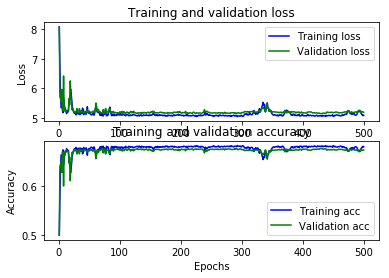

In [20]:
from keras import optimizers
from keras import losses
from keras import metrics

model_dense=dense_model(X_train, dense_units1=128, dense_units2=32)
model_dense.summary()
model_dense.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
history=model_dense.fit(X_train,y_train,epochs=500,batch_size=32,validation_data=(X_test, y_test))
draw_history(history)

## Create dense on embedded data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 800008    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 36        
__________

19823/19823 [==============================] - 117s 6ms/step - loss: 0.6987 - acc: 0.4983 - val_loss: 0.6994 - val_acc: 0.4993
Epoch 49/50
19823/19823 [==============================] - 118s 6ms/step - loss: 0.6987 - acc: 0.4995 - val_loss: 0.6994 - val_acc: 0.4993
Epoch 50/50
19823/19823 [==============================] - 118s 6ms/step - loss: 0.6987 - acc: 0.4986 - val_loss: 0.6993 - val_acc: 0.5007


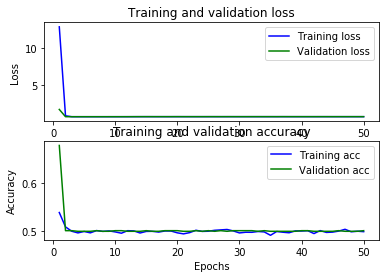

In [21]:
model_embedded_dense=embedding_flatten_model(X_train,max_words=max_words,embedding_units=100,dense_units1=8,dropout=0.5,dense_units2=4,embeddings_regularizer=regularizers.l2(0.15), kernel_regularizer=regularizers.l2(0.15),bias_regularizer=regularizers.l2(0.15),activity_regularizer=regularizers.l2(0.15))
model_embedded_dense.summary()
model_embedded_dense.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
history=model_embedded_dense.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test, y_test))
draw_history(history)

## Create lstm model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
FC1 (Dense)                  (None, 8)                 264       
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 8)                 0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 9         
__________

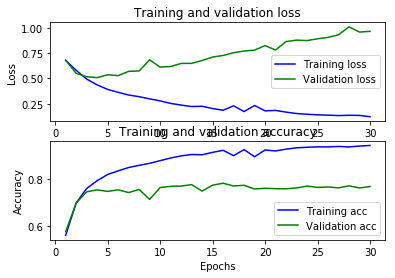

In [22]:
model=lstm_model(X_train, max_words=max_words, embedding_units=100 ,lstm_units=32, dense_units=8, dropout=0, recurrent_dropout=0.2,embeddings_regularizer=None, activity_regularizer=None,kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None)
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(0.0005),metrics=['accuracy'])

history = model.fit(X_train,y_train,batch_size=32,epochs=30, validation_data=(X_test,y_test))

draw_history(history)


## Bidirectional LSTM

In [ ]:
model_bi_lstm=bidirectional_lstm_model(X_train, max_words,embedding_units=100 ,lstm_units=32, dropout=0, recurrent_dropout=0.2)
model_bi_lstm.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(0.001),metrics=['accuracy'])

history = model.fit(X_train,y_train,batch_size=32,epochs=30, validation_data=(X_test,y_test))
draw_history(history)

## CNN

In [24]:
model_cnn=cnn(data=X_train, max_words=max_words, embedding_units=100, conv_1_filter=25,conv_1_length=9, pooling_length= 5,conv_2_filter=32,conv_2_length=9)
model_cnn.summary()

model_cnn.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model_cnn.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0,validation_data=(X_test,y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 992, 25)           22525     
_________________________________________________________________
dropout_16 (Dropout)         (None, 992, 25)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 198, 25)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 190, 32)           7232      
_________________________________________________________________
dropout_17 (Dropout)         (None, 190, 32)           0         
__________

KeyboardInterrupt: 

## CNN and LSTM mixed

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1000)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 994, 32)           22432     
_________________________________________________________________
dropout_18 (Dropout)         (None, 994, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 198, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 192, 32)           7200      
_________________________________________________________________
dropout_19 (Dropout)         (None, 192, 32)           0         
__________

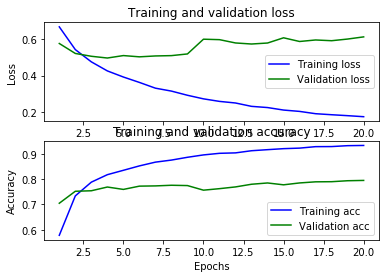

In [25]:
model_cnn_lstm=cnn_lstm_model(X_train, max_words, embedding_units=100,conv_1_filter=32,lstm_units=8,conv_1_length=7, pooling_length= 5,conv_2_filter=32,conv_2_length=7, dropout=0.2,recurrent_dropout=0.2)
model_cnn_lstm.summary()

model_cnn_lstm.compile(optimizer=RMSprop(0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model_cnn_lstm.fit(X_train, y_train,
                    epochs=20,
                    batch_size=500,
                    validation_split=0,validation_data=(X_test,y_test))
draw_history(history)

## Compare pretrained embedded layer with self learned layer

In [ ]:
# Get Glove weights
glove_dir = 'E:\\Marius\\Documents\\Studium\\Programmieren\\Daten\\Text\\glove.840B.300d'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.840B.300d.txt'),'r', encoding='utf8')
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


In [ ]:
# build embedding matrix
embedding_dim = 300
 # Train Tokenizer
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(serie_texts)
word_index=tok.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
embedding_matrix

In [ ]:
model=lstm_model(X_train,max_words=max_words,embedding_units=300,lstm_units=32,dense_units=8,dropout=0.2,embeddings_regularizer=regularizers.l2(0.15), kernel_regularizer=regularizers.l2(0.15),bias_regularizer=regularizers.l2(0.15),activity_regularizer=regularizers.l2(0.15))

#Freeze layer
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable=False

model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

history = model.fit(X_train,y_train,batch_size=32,epochs=30, validation_data=(X_test,y_test))

draw_history(history)

## Test

In [38]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
   
    return model

In [63]:
model_complex=define_model(length=max_len, vocab_size=max_words)
model_complex.summary()

 # compile
model_complex.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model_complex.summary())
#plot_model(model, show_shapes=True, to_file='multichannel.png')
history = model_complex.fit([X_train,X_train,X_train], np.array(y_train),
                    epochs=10,
                    batch_size=500,
                    validation_split=0,validation_data=(X_test,y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 1000, 100)    100000      input_49[0][0]                   
__________________________________________________________________________________________________
embedding_

TypeError: only integer scalar arrays can be converted to a scalar index